## From simulation-based exploration to norm induction and policy deduction



In [1]:
import sys
import os
import random
import numpy as np
import networkx as nx
sys.path.insert(1, '/home/peter/Desktop/postdoc/Prolog-Gym')
#from env_input.ConstraintsHandler import PrologHandler
import matplotlib.pyplot as plt
from environments.dataSharing.dataSharing import DataSharing
from norm_analysis.normStruct import Norm, Instance

import gymnasium as gym
import pandas as pd

os.system('pip install -e /home/peter/Desktop/postdoc/Prolog-Gym')

#from gymnasium.envs.registration import registry
#registry

Obtaining file:///home/peter/Desktop/postdoc/Prolog-Gym
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: environments
    Found existing installation: environments 0.0.1
    Uninstalling environments-0.0.1:
      Successfully uninstalled environments-0.0.1
  Running setup.py develop for environments


0

## Random agent

In [2]:
env_config = {'pathToRules': '/home/peter/Desktop/postdoc/Prolog-Gym/benchmarks/dataSharing/rules.pl',
              'pathToInitialState': '/home/peter/Desktop/postdoc/Prolog-Gym/benchmarks/dataSharing/initialState.pl',
              'spaceType': 'symbolic',
              'agentRL': None
             }
env = gym.make('environments/DataSharing-v0', env_config = env_config)

In [3]:
env.reset()
env.env.handler.makeQuery("citizen(X)")

/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


[{'X': ['Alex Johnson', 29, 'single']},
 {'X': ['Maria Gonzalez', 34, 'married']},
 {'X': ['Kevin Smith', 42, 'divorced']},
 {'X': ['Emily Davis', 27, 'married']},
 {'X': ['James Brown', 31, 'single']}]

In [4]:
l = ["a","b","c"]
"varNames(newData," + str(l) +")"

"varNames(newData,['a', 'b', 'c'])"

In [5]:
max_steps = 10
max_iter = 20

norm = Norm()
for iter in range(max_iter):
    env.reset()
    users = env.env.handler.getAgents('user')
    traj = {}
    for user in users:
        traj[user] = Instance(user)
    
    observation, info = env.reset()
    for i in range(max_steps):
        for user in users:
            if not traj[user].terminated:
                action = env.env.randomAllowedAction(agent=user)
            else:
                action = {'action': 'nullAction', 'X0': user}

            new_observation, reward, terminated, truncated, info = env.step(action)
            traj[user].append(observation, action, new_observation, reward, info)
            traj[user].terminated = terminated
            traj[user].truncated = truncated
             
            observation = new_observation#.copy()
            #if terminated == True or truncated == True:
            #    break
    for user in users:
        norm.addInstance(user, iter, traj[user], unique='endStateEqualTo')

/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


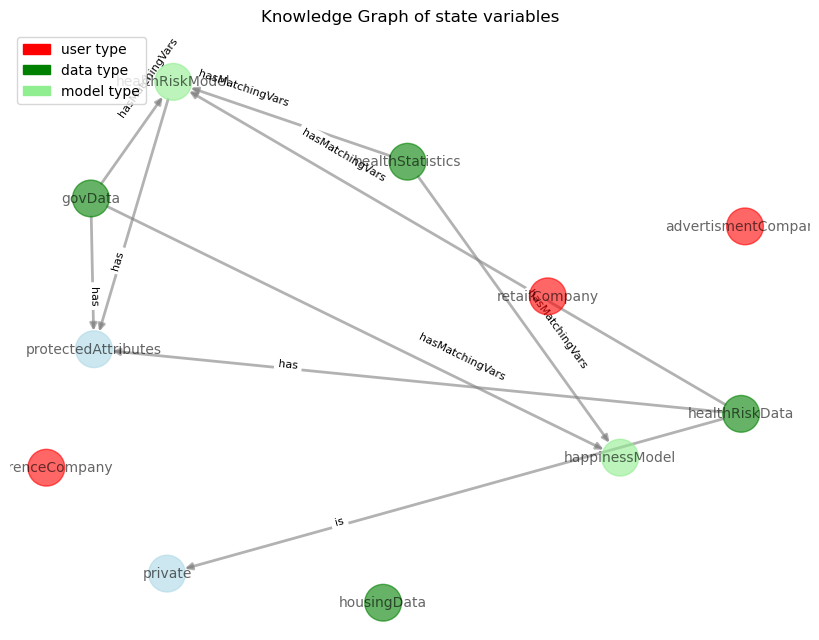

In [6]:
#plot initial state, consider:https://github.com/paulbrodersen/netgraph

G = nx.DiGraph()
init_obs, init_info = env.reset()


user_col = 'red'
data_col = 'green'
model_col = 'lightgreen'
private_col = 'lightblue'
protectedAttributes_col = 'lightblue'

for state_fact in init_info['dictState']:
    if state_fact['fact'] == 'user':
        G.add_node(state_fact['X0'], color = user_col)
    elif state_fact['fact'] == 'data':
        G.add_node(state_fact['X0'], color = data_col)
    elif state_fact['fact'] == 'model':
        G.add_node(state_fact['X0'], color = model_col)


df = env.getStateAsTriplets(init_info['dictState'])
for _, row in df.iterrows():
    G.add_edge(row['head'], row['tail'], relation=row['relation'])

G.add_node('private', color = private_col)
G.add_node('protectedAttributes', color = protectedAttributes_col)
for state_fact in init_info['dictState']:
    if state_fact['fact'] == 'private':
        G.add_edge(state_fact['X0'], 'private', relation='is')
    if state_fact['fact'] == 'hasProtectedAttributes':
        G.add_edge(state_fact['X0'], 'protectedAttributes', relation='has')


colors = nx.get_node_attributes(G, 'color').values()

pos = nx.circular_layout(G)
pos = nx.planar_layout(G)
pos = nx.spring_layout(G, k=0.95, iterations=10)
labels = nx.get_edge_attributes(G, 'relation')
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=colors, edge_color='gray', alpha=0.6, width = 2)#, connectionstyle='arc3, rad = 0.1')
#nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, edge_color='gray', alpha=0.6)#, connectionstyle='arc3, rad = 0.1')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph of state variables')


userArt = plt.Circle((0, 0), 0, color=user_col)
dataArt = plt.Circle((0, 0), 0, color=data_col)
modelArt = plt.Circle((0, 0), 0, color=model_col)
plt.legend([userArt, dataArt, modelArt], ['user type','data type','model type'], loc='upper left')

#plt.legend(["blue", "green"], loc="upper left")

plt.show()

In [7]:
terminated_count = 0
for traj_id, traj in norm.instances.items():
    print(traj_id, traj.terminated)
    if traj.terminated == True:
        terminated_count = terminated_count + 1
        #print(traj.observation)

terminated_count/len(norm.instances)

('insurenceCompany', 0) True
('advertismentCompany', 0) True
('retailCompany', 0) True
('insurenceCompany', 1) False
('advertismentCompany', 1) False
('retailCompany', 1) False
('insurenceCompany', 2) True
('advertismentCompany', 2) True
('retailCompany', 2) True
('insurenceCompany', 3) True
('advertismentCompany', 3) True
('retailCompany', 3) True
('insurenceCompany', 4) True
('advertismentCompany', 4) True
('retailCompany', 4) True
('insurenceCompany', 5) False
('advertismentCompany', 5) False
('retailCompany', 5) False
('insurenceCompany', 6) False
('advertismentCompany', 6) False
('retailCompany', 6) False
('insurenceCompany', 7) True
('advertismentCompany', 7) True
('retailCompany', 7) True
('insurenceCompany', 8) False
('advertismentCompany', 8) False
('retailCompany', 8) False
('insurenceCompany', 9) False
('advertismentCompany', 9) False
('retailCompany', 9) False
('insurenceCompany', 10) True
('advertismentCompany', 10) True
('retailCompany', 10) True
('insurenceCompany', 11) 

0.6

## RL agent

In [8]:
env_config = {'pathToRules': '/home/peter/Desktop/postdoc/Prolog-Gym/benchmarks/dataSharing/rules.pl',
              'pathToInitialState': '/home/peter/Desktop/postdoc/Prolog-Gym/benchmarks/dataSharing/initialState.pl',
              'spaceType': 'encoded',
              'agentRL': 'insurenceCompany'
             }
env = gym.make('environments/DataSharing-v0', env_config = env_config)

print("number of actions ", env.action_space.n, "for ", env_config['agentRL'])

number of actions  11 for  insurenceCompany


In [9]:
from ray.rllib.algorithms.ppo import PPOConfig
import ray
ray.init(ignore_reinit_error=True, num_cpus=8)

2024-05-31 16:55:27,626	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.9.18
Ray version:,2.9.2


In [10]:
from ray.rllib.models import ModelCatalog
from environments.dataSharing.dataSharing import ActionMaskModel, DataSharing
ModelCatalog.register_custom_model("pa_model", ActionMaskModel)

algo = (
    PPOConfig()
    .framework('tf2', eager_max_retraces = None)
    .rollouts(num_rollout_workers=7)
    .resources(num_cpus_per_worker=1)
    .training(gamma=0.90, lr=0.001, use_critic = True, train_batch_size=5*128, kl_coeff=0.0, model={"custom_model": "pa_model", })#, entropy_coeff = 1.0) 
    .environment(env=DataSharing, env_config=env_config, auto_wrap_old_gym_envs = False)
    .build()
)

#put very big batch, low rate and a lot of updates --must work!

/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning

(raylet) [2024-05-31 16:55:36,592 E 11227 11250] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-31_16-55-24_941211_10703 is over 95% full, available space: 17094561792; capacity: 496831381504. Object creation will fail if spilling is required.
(RolloutWorker pid=11619) 2024-05-31 16:55:36,890	WARNING env.py:162 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=11619) /home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
(RolloutWorker pid=11619)   ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
(raylet) [2024-05-31 16:55:46,613 E 11227 11250] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-31_16-55-24_941211_10703 is over 95% full, available space: 17094553600; capacity: 496831381504. Object creation will fail if spilling is required.
(raylet) [2024-

In [11]:
from ray.tune.logger import pretty_print
results = []
for i in range(10):
    result = algo.train()
    results.append(result)
    print(pretty_print(result))

2024-05-31 16:55:42,334	WARNING deprecation.py:50 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


agent_timesteps_total: 640
connector_metrics:
  ObsPreprocessorConnector_ms: 0.13267312731061665
  StateBufferConnector_ms: 0.047786273653545076
  ViewRequirementAgentConnector_ms: 0.4629483298649863
counters:
  num_agent_steps_sampled: 640
  num_agent_steps_trained: 640
  num_env_steps_sampled: 640
  num_env_steps_trained: 640
custom_metrics: {}
date: 2024-05-31_16-55-45
done: false
episode_len_mean: 40.77777777777778
episode_media: {}
episode_reward_max: 520.0
episode_reward_mean: 297.77777777777777
episode_reward_min: 20.0
episodes_this_iter: 9
episodes_total: 9
hostname: peter-XPS-13-7390
info:
  learner:
    default_policy:
      custom_metrics: {}
      diff_num_grad_updates_vs_sampler_policy: 74.5
      learner_stats:
        cur_kl_coeff: 0.0
        cur_lr: 0.0010000000474974513
        entropy: 0.13003849983215332
        entropy_coeff: 0.0
        kl: 0.0
        policy_loss: -0.03827137500047684
        total_loss: 0.946161687374115
        vf_explained_var: 1.1682510603350

In [12]:
for res in results:
    print(res['hist_stats']['episode_reward'])

[520.0, 520.0, 20.0, 20.0, 520.0, 520.0, 20.0, 520.0, 20.0]
[520.0, 520.0, 20.0, 20.0, 520.0, 520.0, 20.0, 520.0, 20.0, 520.0, 520.0, 520.0, 20.0, 520.0, 20.0, 20.0, 20.0, 520.0, 520.0, 520.0, 20.0, 520.0, 20.0, 20.0, 520.0]
[520.0, 520.0, 20.0, 20.0, 520.0, 520.0, 20.0, 520.0, 20.0, 520.0, 520.0, 520.0, 20.0, 520.0, 20.0, 20.0, 20.0, 520.0, 520.0, 520.0, 20.0, 520.0, 20.0, 20.0, 520.0, 20.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0]
[520.0, 520.0, 20.0, 20.0, 520.0, 520.0, 20.0, 520.0, 20.0, 520.0, 520.0, 520.0, 20.0, 520.0, 20.0, 20.0, 20.0, 520.0, 520.0, 520.0, 20.0, 520.0, 20.0, 20.0, 520.0, 20.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 20.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0, 520.0]
[520.0, 520.0, 20.0, 20.0, 520.0, 520.0, 20.0, 520.0, 20.0, 520.0, 520.0, 520.0, 20.0, 520.0, 20.0

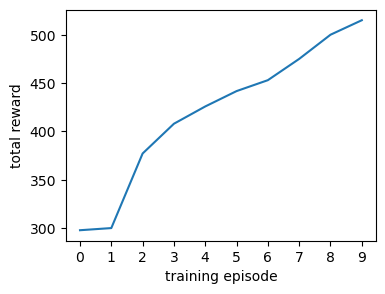

In [23]:
meanRewards = []
for res in results:
    meanRewards.append(res['episode_reward_mean'])
    #meanRewards = meanRewards + res['hist_stats']['episode_reward']


plt.figure(figsize=(4, 3))
plt.plot(meanRewards)



plt.ylabel('total reward')
plt.xlabel('training episode')
plt.xticks(np.arange(0,10,1) )
plt.show()

In [24]:
max_steps = 10
max_iter = 1000

norm = Norm()
for iter in range(max_iter):
    env.reset()
    users = env.env.handler.getAgents('user')
    traj = {}
    for user in users:
        traj[user] = Instance(user)
    
    observation, info = env.reset()
    for i in range(max_steps):
        for user in users:
            if not traj[user].terminated:
                if user == env_config['agentRL']:
                    action = algo.compute_single_action(observation)
                else:
                    action = env.env.randomAllowedAction(agent=user)
            else:
                action = {'action': 'nullAction', 'X0': user}

            new_observation, reward, terminated, truncated, info = env.step(action)
            traj[user].append(observation, action, new_observation, reward, info)
            traj[user].terminated = terminated
            traj[user].truncated = truncated
             
            observation = new_observation#.copy()
            #if terminated == True or truncated == True:
            #    break
    for user in users:
        norm.addInstance(user, iter, traj[user], unique='endStateEqualTo')

In [25]:
terminated_count = 0
for traj_id, traj in norm.instances.items():
    #print(traj_id, traj.terminated)
    if traj.terminated == True:
        terminated_count = terminated_count + 1
        #print(traj.observation)

terminated_count/len(norm.instances)

0.1925841846386682

In [26]:
res = env.handler.makeQuery('data(X)')
datas = [d['X'] for d in res]
res = env.handler.makeQuery('model(X)')
models = [d['X'] for d in res]
dm = datas + models

accessList = []
accessDict = {}

for traj_id, traj in norm.instances.items():
    user = traj_id[0]
    id = traj_id[1]

    accessDict[traj_id] = {}

    tmp_dict = {}
    tmp_dict['id'] = id
    tmp_dict['user'] = user
    tmp_dict.update(dict(zip(dm, [False]*len(dm))))

    for fact in traj.info[-1]['dictState']:
        if fact['fact'] == 'hasAccess' and user == fact['X0']:
            tmp_dict[fact['X1']] = True
            if fact['X1'] in models:
                accessDict[traj_id]['model'] = fact['X1']
            elif fact['X1'] in datas:
                accessDict[traj_id]['data'] = fact['X1']
            else:
                print("warning:", fact['X1'], " is not data nor model")
    accessList.append(tmp_dict)
    


import pandas as pd
accessDF = pd.DataFrame.from_dict(accessList)
accessDF.head(20)

,id,user,govData,healthRiskData,healthStatistics,housingData,newDatainsurenceCompany6,newDataretailCompany17,healthRiskModel,happinessModel
0,0,insurenceCompany,False,False,True,False,False,False,False,True
1,0,advertismentCompany,False,False,False,True,False,False,False,True
2,0,retailCompany,False,False,True,True,False,False,False,False
3,1,insurenceCompany,False,False,True,False,False,False,True,False
4,1,advertismentCompany,False,False,False,True,False,False,True,False
5,1,retailCompany,False,False,True,False,False,False,False,True
6,2,insurenceCompany,False,False,True,False,False,False,True,False
7,2,advertismentCompany,False,False,True,False,False,False,True,False
8,2,retailCompany,True,False,True,False,False,False,False,False
9,3,insurenceCompany,False,False,True,False,False,False,False,True


In [27]:
accessDict[('insurenceCompany', 0)]

{'model': 'happinessModel', 'data': 'healthStatistics'}

In [28]:

lines = []
for traj_id,traj in norm.instances.items():
    tw_write = ''
    sid = str(traj_id[1])
    #clause = 'norm(insurenceCompany'+sid+',healthRiskData'+sid+',hospitalData'+sid+',govData'+sid+')'
    #clause = 'norm(insurenceCompany'+sid+',healthRiskData'+sid+')'
    if len(accessDict[traj_id]) == 2:
        argUser = traj_id[0]
        
        arg0 = accessDict[traj_id]['data']
        arg1 = accessDict[traj_id]['model']

        #clause = 'norm(insurenceCompany'+sid+','+arg0+sid+','+arg1+sid+')'
        clause = 'norm('+argUser+sid+','+arg0+sid+','+arg1+sid+')'
        if traj.terminated == True:
            #to_write = 'pos(norm(insurenceCompany'+sid+',healthRiskData'+sid+',hospitalData'+sid+',govData'+sid+',groceriesData'+sid+')).'
            to_write = 'pos(' + clause + ').'
        elif traj.terminated == False:
            to_write = 'neg(' + clause + ').'
        else:
            print("Unlabeled instance! ", id)
        lines.append(to_write)
    else:
        print("incorrect len ", traj_id, " ", accessDict[traj_id])

with open('popper/exs.pl', 'w') as f:
    for line in sorted(lines, reverse=True):
        f.write(f"{line}\n")

incorrect len  ('retailCompany', 0)   {'data': 'housingData'}
incorrect len  ('retailCompany', 2)   {'data': 'govData'}
incorrect len  ('advertismentCompany', 3)   {'data': 'housingData'}
incorrect len  ('advertismentCompany', 9)   {'data': 'housingData'}
incorrect len  ('advertismentCompany', 10)   {'data': 'healthStatistics'}
incorrect len  ('retailCompany', 10)   {'data': 'govData'}
incorrect len  ('advertismentCompany', 12)   {'data': 'govData'}
incorrect len  ('advertismentCompany', 13)   {'data': 'housingData'}
incorrect len  ('retailCompany', 13)   {'data': 'healthStatistics'}
incorrect len  ('advertismentCompany', 14)   {'data': 'healthStatistics'}
incorrect len  ('advertismentCompany', 15)   {'data': 'govData'}
incorrect len  ('retailCompany', 15)   {'data': 'healthStatistics'}
incorrect len  ('retailCompany', 17)   {'data': 'govData'}
incorrect len  ('retailCompany', 18)   {'data': 'govData'}
incorrect len  ('advertismentCompany', 20)   {'data': 'housingData'}
incorrect len  

In [29]:
def getEntities(env, entity_types = ['user', 'data', 'model']):
    entities = set()
    for entity in entity_types:
        for sol in env.handler.makeQuery(entity + '(X)'):
            entities.add(sol['X'])
    return entities

entities = getEntities(env)

lines = []
for traj_id, traj in norm.instances.items():
    user = traj_id[0]
    id = traj_id[1]
    if user == env_config['agentRL']:
        to_write = traj.info[-1]['formatState'].copy()
        for i in range(len(to_write)):
            for entity in entities:
                to_write[i] = to_write[i].replace(entity, entity + str(id) )



            to_write[i] = to_write[i] + '.'
        lines = lines + to_write



with open('popper/bk.pl', 'w') as f:
    for line in sorted(lines):
        f.write(f"{line}\n")

In [30]:
sys.path.insert(1, '/home/peter/Desktop/postdoc/normBuilding/Popper')

#need to be run with cybersim kernel
from popper.util import Settings, print_prog_score
from popper.loop import learn_solution

In [31]:
#try with size 4 and if you get correct noisy ansewer then be done with it

noiz = False
settings = Settings(kbpath='/home/peter/Desktop/postdoc/Prolog-Gym/benchmarks/dataSharing/popper',
                    show_stats=False, 
                    noisy=noiz,
                    timeout = 6*600)

#/home/peter/Desktop/postdoc/normBuilding/Popper/examples/noisy-wn18rr1

#settings.max_body = 20
#settings.max_vars = 15
#settings.max_rules = 15

prog, score, stats = learn_solution(settings)
if prog != None:
    print_prog_score(prog, score, noisy=noiz)
    #settings.print_prog_score(prog, score)
else:
    print('NO SOLUTION')
if settings.show_stats:
    stats.show()

17:47:35 Generating programs of size: 2
17:47:37 Generating programs of size: 3
18:01:48 Generating programs of size: 4
18:17:53 ********************
18:17:53 New best hypothesis:
18:17:53 tp:173 fn:269 tn:1492 fp:0 size:4
18:17:53 norm(A,B,C):- hasProtectedAttributes(B),performedInference(A,B,C),hasProtectedAttributes(C).
18:17:53 ********************
18:52:39 TIMEOUT OF 3600 SECONDS EXCEEDED


********** SOLUTION **********
Precision:1.00 Recall:0.39 TP:173 FN:269 TN:1492 FP:0 Size:4
norm(A,B,C):- hasProtectedAttributes(B),performedInference(A,B,C),hasProtectedAttributes(C).
******************************


In [32]:
for item in prog:
    if len(prog) > 1:
        print("Warning: more than one solution")
    predicateList = []
    for inside_item in item[1]:
        #print(inside_item.__dict__.items())
        predicate = inside_item.predicate
        predicate = predicate + '(' + ','.join(inside_item.arguments) + ')'
        predicateList.append(predicate)

predicateList

['hasProtectedAttributes(B)',
 'performedInference(A,B,C)',
 'hasProtectedAttributes(C)']